### Análisis de Resultados Task 1 - Metabu

Este notebook analiza los resultados del Task 1, mostrando la comparación entre diferentes meta-features usando gráficos de cajas.


In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuración de estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.size'] = 11

# Cargar datos
results_file = 'results_task1/task1_results.csv'
df = pd.read_csv(results_file)

print(f"Total de registros: {len(df)}")
print(f"\nColumnas: {df.columns.tolist()}")
print(f"\nPipelines: {df['pipeline'].unique()}")
print(f"Meta-features: {df['metafeature'].unique()}")
print(f"Valores de k: {sorted(df['ndcg'].unique())}")
print(f"\nPrimeras filas:")
df.head()


Total de registros: 3073

Columnas: ['pipeline', 'metafeature', 'openml_tid', 'ndcg', 'ndcg_score']

Pipelines: ['adaboost' 'random_forest' 'libsvm_svc']
Meta-features: ['metabu' 'AutoSklearn' 'Landmark' 'SCOT']
Valores de k: [np.int64(10), np.int64(15), np.int64(20), np.int64(25)]

Primeras filas:


,pipeline,metafeature,openml_tid,ndcg,ndcg_score
0,adaboost,metabu,3,15,0.533333
1,adaboost,metabu,3,10,0.600000
2,adaboost,metabu,6,10,0.600000
3,adaboost,metabu,11,10,0.600000
4,adaboost,metabu,12,10,0.500000


In [215]:
# Mapeo de nombres para mejor visualización
metafeature_names = {
    'metabu': 'Metabu MF',
    'AutoSklearn': 'AutoSklearn MF',
    'Landmark': 'Landmark MF',
    'SCOT': 'SCOT MF'
}

# Crear columna con nombres formateados
df['metafeature_label'] = df['metafeature'].map(metafeature_names)

# Verificar distribución de datos
print("Distribución por pipeline y meta-feature:")
print(df.groupby(['pipeline', 'metafeature']).size().unstack(fill_value=0))


Distribución por pipeline y meta-feature:
metafeature    AutoSklearn  Landmark  SCOT  metabu
pipeline                                          
adaboost               256       256   256     257
libsvm_svc             256       256   256     256
random_forest          256       256   256     256


### Gráficos de Cajas por Pipeline


#### Por qué hacer este análisis basado en un gráfico por cajas.

En AutoML y Meta-learning no evaluamos *un dataset*, sino *muchos datasets distintos*, por lo que la pregunta correcta no es ¿qué método tiene mejor promedio?, sino ¿qué método funciona de manera confiable en muchos datasets?.

#### La métrica a utilizar
Para cada dataset, el metalearner produce un ranking de *configuraciones*. La medida NDCG@k arroja qué tan arriba en ese ranking aparece la mejor configuración real. Luego para cada dataset se genera un número. En nuestro caso (64 datasets), tendríamos 64 valores de NDCG@k.

#### Boxplot
El gráfico de cajas toma los valores y muestra su distribución y tiene la siguiente estructura:
- Línea central: representa el dataset típico (la mediana).
- Caja: representa el 50% central de los datasets.
- Bigotes: representa el rango normal.
- Puntos: representa los datasets para difíciles. Entiéndase por esto aquellos datasets para los cuales el modelo no logró producir un buen ranking.

Atendiendo a estas características el gráfico de cajas *no solo muestra promedio, sino también muestra estabilidad*.

La pregunta ahora sería ¿qué demuestra?
Si el boxplot de MetafeatX se encuentra:
- más alto
- más compacto
- con menos outliers

significa que MetafeatX no solo gana en promedio, sino también en la mayoría de los datasets, lo cual evidencia *transferencia real*.

#### Necesidad

En la práctica el usuario no sabe qué dataset tendrá y requiere de un método que funcione bien "casi siempre". El boxplot responde exactamente a eso.

#### Estructura de la gráfica
Para cada pipeline, mostramos gráficos de cajas donde:
- **Eje X**: Valores de k evaluados (NDCG@k)
- **Eje Y**: NDCG score
- **4 cajas por cada k**, una para cada meta-feature


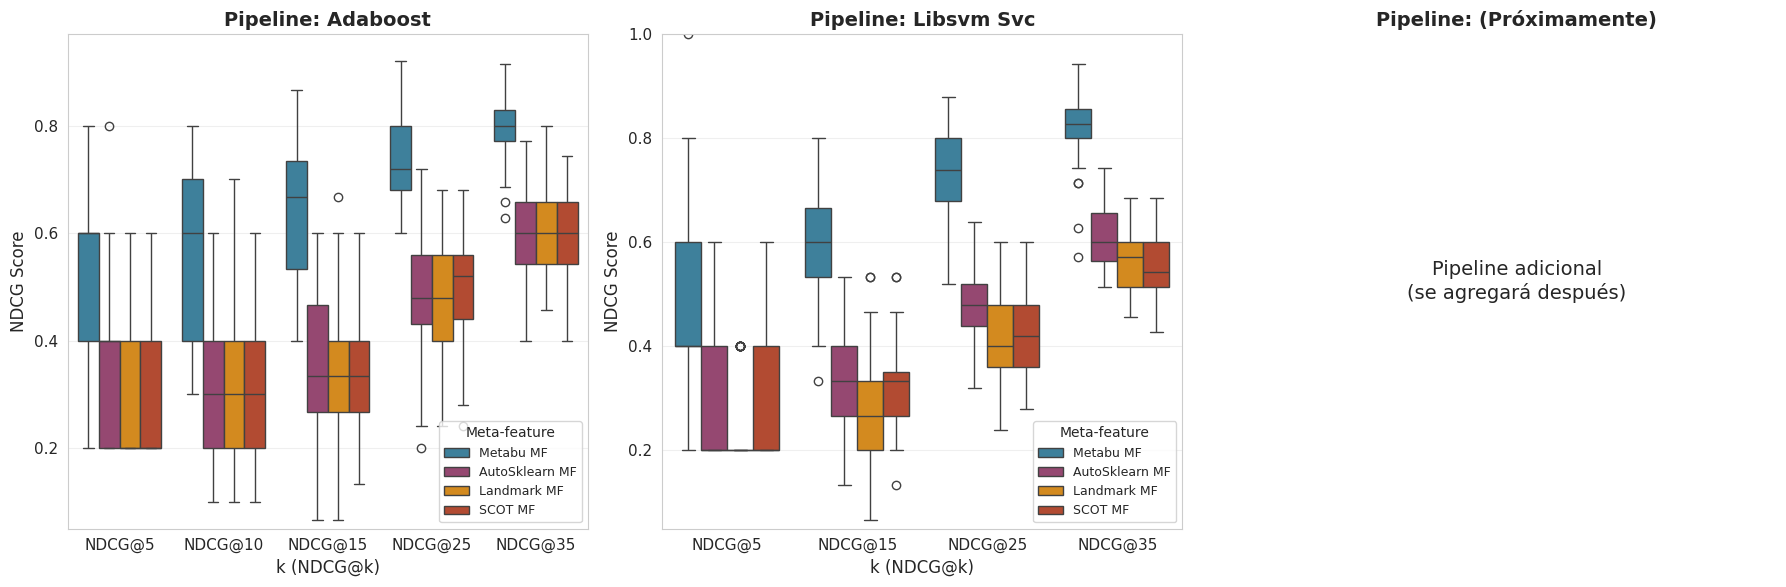


📊 Datos cargados:
   - Total de registros: 2303
   - Pipelines: ['adaboost' 'libsvm_svc']
   - Meta-features: ['metabu' 'AutoSklearn' 'Landmark' 'SCOT']
   - Valores de k: [np.int64(5), np.int64(10), np.int64(15), np.int64(25), np.int64(35)]


In [ ]:
# Ordenar meta-features para consistencia en todos los gráficos
metafeature_order = ['Metabu MF', 'AutoSklearn MF', 'Landmark MF', 'SCOT MF']
df['metafeature_label'] = pd.Categorical(df['metafeature_label'], categories=metafeature_order, ordered=True)

# Obtener pipelines únicos
pipelines = sorted(df['pipeline'].unique())
n_pipelines = len(pipelines)

# Colores para cada meta-feature
colors = {'Metabu MF': '#2E86AB', 'AutoSklearn MF': '#A23B72', 'Landmark MF': '#F18F01', 'SCOT MF': '#C73E1D'}

# Crear subplots usando seaborn (más limpio)
fig, axes = plt.subplots(1, n_pipelines, figsize=(6*n_pipelines, 6))

if n_pipelines == 1:
    axes = [axes]

for idx, pipeline in enumerate(pipelines):
    ax = axes[idx]
    pipeline_data = df[df['pipeline'] == pipeline].copy()
    
    # Crear columna combinada para el eje X: k + metafeature
    pipeline_data['k_label'] = pipeline_data['ndcg'].astype(str).apply(lambda x: f"NDCG@{x}")
    
    # Calcular rango dinámico del eje Y basado en los datos
    # Separar Metabu de los baselines para mejor visualización
    metabu_data = pipeline_data[pipeline_data['metafeature_label'] == 'Metabu MF']['ndcg_score']
    baselines_data = pipeline_data[pipeline_data['metafeature_label'] != 'Metabu MF']['ndcg_score']
    
    # Calcular rangos separados
    metabu_min = metabu_data.min() if len(metabu_data) > 0 else 0
    metabu_max = metabu_data.max() if len(metabu_data) > 0 else 1
    baselines_min = baselines_data.min() if len(baselines_data) > 0 else 0
    baselines_max = baselines_data.max() if len(baselines_data) > 0 else 1
    
    # Rango global ajustado que muestre bien tanto Metabu como baselines
    y_min = min(metabu_min, baselines_min)
    y_max = max(metabu_max, baselines_max)
    y_min_adjusted = max(0.05, y_min - 0.08)  # Pequeño margen inferior, mínimo 0.05
    y_max_adjusted = min(1.0, y_max + 0.05)  # Pequeño margen superior
    
    # Boxplot usando seaborn
    sns.boxplot(data=pipeline_data, 
                x='k_label', 
                y='ndcg_score', 
                hue='metafeature_label',
                ax=ax,
                palette=colors,
                order=[f"NDCG@{k}" for k in sorted(pipeline_data['ndcg'].unique())])
    
    ax.set_ylabel('NDCG Score', fontsize=12)
    ax.set_xlabel('k (NDCG@k)', fontsize=12)
    ax.set_title(f'Pipeline: {pipeline.replace("_", " ").title()}', fontsize=14, fontweight='bold')
    ax.set_ylim(y_min_adjusted, y_max_adjusted)  # Rango dinámico ajustado a los datos
    ax.legend(title='Meta-feature', title_fontsize=10, fontsize=9, loc='best')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results_task1/figures/boxplot_task1_by_pipeline.png', dpi=300, bbox_inches='tight')
plt.show()


### Observaciones

En el caso de uso de adaboost como pipeline se aprecia una compactación de la caja de MetafeatX a medida que aumentan los valores de $k$, así también como un buen rendimiento general del NDCG score en comparación con el resto de metafeatures definidas por AutoSKlearn, Landmark y SCOT. Esta situación es similar en el resto de pipelines, por lo que se puede decir que a grandes rasgos MetafeatX logra el objetivo de recomendar mejores *configuraciones* respecto a las metafeatures predefinidas.

## Mean NDCG@k vs Training Size

Visualización de las curvas de aprendizaje para MetaFeatX y AutoSklearn.


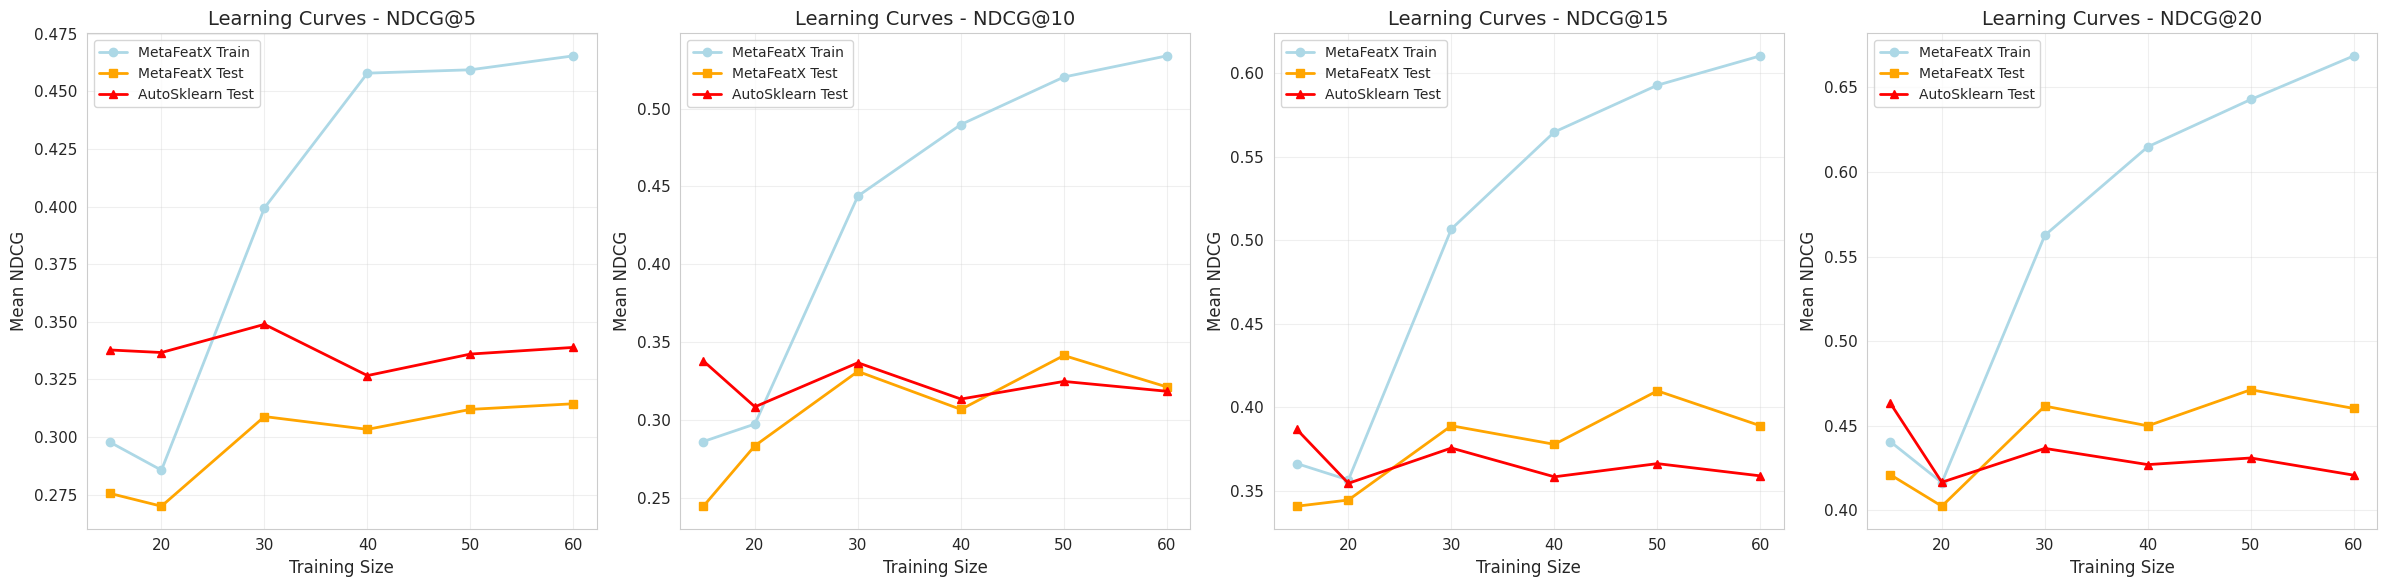

In [217]:
# Cargar datos de curvas de aprendizaje
learning_curve_file = 'results_task1/learning_curve_loo_default.csv'
df_learning = pd.read_csv(learning_curve_file)

# Obtener valores únicos de k
k_values = sorted(df_learning['ndcg_k'].unique())
n_k = len(k_values)

# Crear subplots para cada k
fig, axes = plt.subplots(1, n_k, figsize=(6*n_k, 6))

if n_k == 1:
    axes = [axes]

# Filtrar los datos según los requisitos:
# MetaFeatX train: azul claro
# MetaFeatX test: naranja
# AutoSklearn test: rojo
# Ignorar AutoSklearn train

for idx, k in enumerate(k_values):
    ax = axes[idx]
    
    # Filtrar datos para este k específico
    df_k = df_learning[df_learning['ndcg_k'] == k]
    
    metafeatx_train = df_k[(df_k['method'] == 'metafeatx') & (df_k['split'] == 'train')]
    metafeatx_test = df_k[(df_k['method'] == 'metafeatx') & (df_k['split'] == 'test')]
    autosklearn_test = df_k[(df_k['method'] == 'autosklearn') & (df_k['split'] == 'test')]
    
    # Agregar por training_size (promediar sobre repeat)
    metafeatx_train_agg = metafeatx_train.groupby('training_size')['mean_ndcg'].mean().reset_index()
    metafeatx_test_agg = metafeatx_test.groupby('training_size')['mean_ndcg'].mean().reset_index()
    autosklearn_test_agg = autosklearn_test.groupby('training_size')['mean_ndcg'].mean().reset_index()
    
    # Graficar las curvas
    ax.plot(metafeatx_train_agg['training_size'], metafeatx_train_agg['mean_ndcg'], 
            label='MetaFeatX Train', color='lightblue', linewidth=2, marker='o')
    ax.plot(metafeatx_test_agg['training_size'], metafeatx_test_agg['mean_ndcg'], 
            label='MetaFeatX Test', color='orange', linewidth=2, marker='s')
    ax.plot(autosklearn_test_agg['training_size'], autosklearn_test_agg['mean_ndcg'], 
            label='AutoSklearn Test', color='red', linewidth=2, marker='^')
    
    ax.set_xlabel('Training Size', fontsize=12)
    ax.set_ylabel('Mean NDCG', fontsize=12)
    ax.set_title(f'Learning Curves - NDCG@{k}', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results_task1/figures/learning_curve_loocv.png', dpi=300, bbox_inches='tight')
plt.show()


## NDCG@20 Mean Training Score vs Test Score

Esta curva mide la *transferencia de conocimiento entre tareas*, o sea, cuánta experiencia previa necesita el metalearner para ser útil.

La elección de NDCG@k para k = 20 se debe a que lo que se busca es observar *qué tan bien el sistema ordena el espacio completo de configuraciones*.

### Construcción

Para cada dataset, entrenamos el metalearner en un subconjunto creciente de tareas, lo validamos en las tareas restantes y lo evaluamos exclusivamente en el dataset dejado fuera, promediando luego los resultados para obtener la curva de aprendizaje.

/tmp/ipykernel_8320/4270061236.py:71: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(stats_autosklearn['training_size'], stats_autosklearn['mean_ndcg'],



📊 Gap (Training - Test):
   - Gap promedio: 0.1250
   - Gap máximo: 0.1678 (s=50)
   - Gap mínimo: -0.0018 (s=20)

✅ Gráfica guardada en: results_task1/figures/training_vs_test_score.png

📊 RESUMEN:
   - Mejor Training Score: 0.6528 (s=60)
   - Mejor Test Score: 0.5055 (s=60)
   - Mejora Training: 0.2561
   - Mejora Test: 0.1070


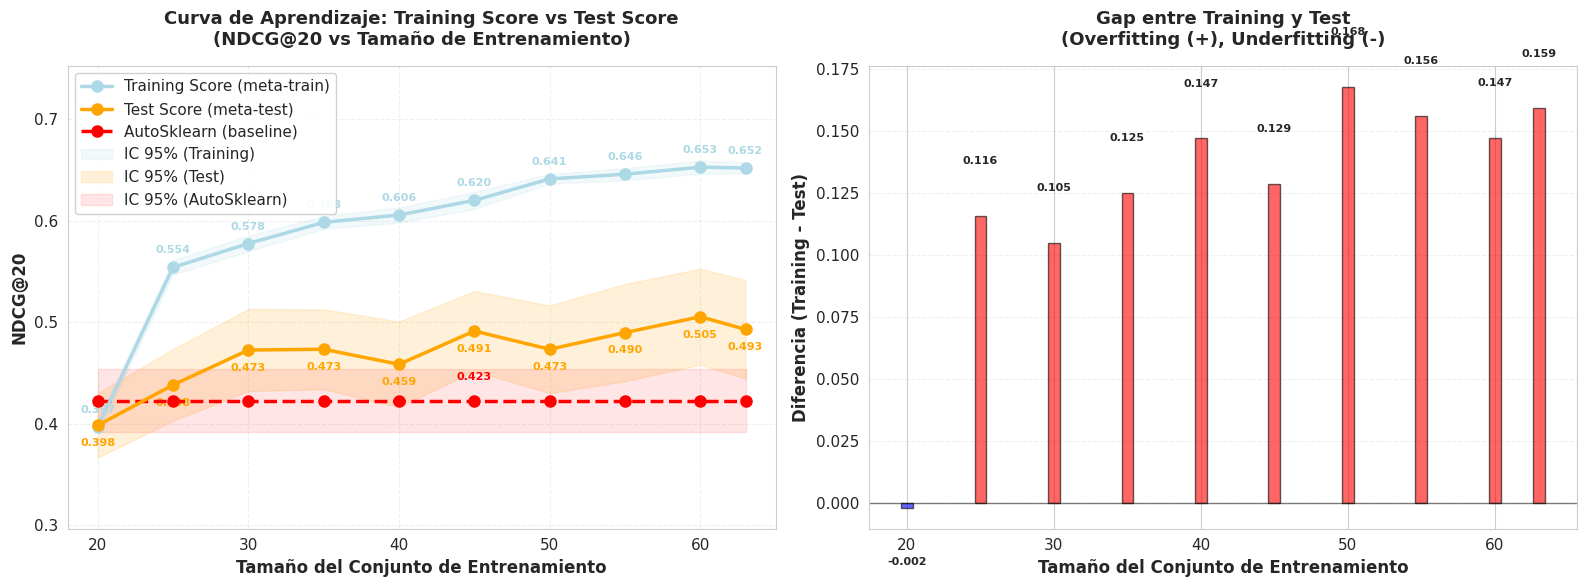

In [218]:
# Configurar estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['font.size'] = 11

# Cargar datos
df = pd.read_csv('results_task1/meta_learning_curve_train_test_ndcg20.csv')

# Separar por split
df_training = df[df['split'] == 'training'].copy()
df_test = df[df['split'] == 'test'].copy()

# Verificar si hay baseline de AutoSklearn
df_autosklearn = df[df['split'].str.contains('baseline_autosklearn_test', case=False, na=False)].copy()
has_autosklearn = len(df_autosklearn) > 0

# Calcular estadísticas por tamaño de entrenamiento
stats_training = df_training.groupby('training_size')['ndcg_score'].agg([
    'mean', 'std', 'count', 'min', 'max'
]).reset_index()
stats_training.columns = ['training_size', 'mean_ndcg', 'std_ndcg', 'n', 'min_ndcg', 'max_ndcg']

stats_test = df_test.groupby('training_size')['ndcg_score'].agg([
    'mean', 'std', 'count', 'min', 'max'
]).reset_index()
stats_test.columns = ['training_size', 'mean_ndcg', 'std_ndcg', 'n', 'min_ndcg', 'max_ndcg']

# Calcular error estándar
stats_training['se'] = stats_training['std_ndcg'] / np.sqrt(stats_training['n'])
stats_training['ci_95_lower'] = stats_training['mean_ndcg'] - 1.96 * stats_training['se']
stats_training['ci_95_upper'] = stats_training['mean_ndcg'] + 1.96 * stats_training['se']

stats_test['se'] = stats_test['std_ndcg'] / np.sqrt(stats_test['n'])
stats_test['ci_95_lower'] = stats_test['mean_ndcg'] - 1.96 * stats_test['se']
stats_test['ci_95_upper'] = stats_test['mean_ndcg'] + 1.96 * stats_test['se']

# Calcular estadísticas para AutoSklearn
stats_autosklearn = df_autosklearn.groupby('training_size')['ndcg_score'].agg([
    'mean', 'std', 'count', 'min', 'max'
]).reset_index()
stats_autosklearn.columns = ['training_size', 'mean_ndcg', 'std_ndcg', 'n', 'min_ndcg', 'max_ndcg']
stats_autosklearn['se'] = stats_autosklearn['std_ndcg'] / np.sqrt(stats_autosklearn['n'])
stats_autosklearn['ci_95_lower'] = stats_autosklearn['mean_ndcg'] - 1.96 * stats_autosklearn['se']
stats_autosklearn['ci_95_upper'] = stats_autosklearn['mean_ndcg'] + 1.96 * stats_autosklearn['se']

# Crear figura
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Grafica 1: Curva Training vs Test
ax1 = axes[0]

# Ordenar por training_size
stats_training = stats_training.sort_values('training_size')
stats_test = stats_test.sort_values('training_size')
if has_autosklearn:
    stats_autosklearn = stats_autosklearn.sort_values('training_size')

# Plot training score (azul claro)
ax1.plot(stats_training['training_size'], stats_training['mean_ndcg'], 
            'o-', linewidth=2.5, markersize=8, color='lightblue', 
            markerfacecolor='lightblue', markeredgecolor='lightblue',
            label='Training Score (meta-train)', zorder=5)

# Plot test score (naranja)
ax1.plot(stats_test['training_size'], stats_test['mean_ndcg'], 
            'o-', linewidth=2.5, markersize=8, color='orange', 
            markerfacecolor='orange', markeredgecolor='orange',
            label='Test Score (meta-test)', zorder=5)

# Plot AutoSklearn baseline (rojo) si existe
ax1.plot(stats_autosklearn['training_size'], stats_autosklearn['mean_ndcg'], 
            'o-', linewidth=2.5, markersize=8, color='red', 
            markerfacecolor='red', markeredgecolor='red',
            label='AutoSklearn (baseline)', zorder=4, linestyle='--')

# Sombreado para intervalo de confianza 95% - training
ax1.fill_between(stats_training['training_size'], 
                    stats_training['ci_95_lower'], 
                    stats_training['ci_95_upper'],
                    alpha=0.15, color='lightblue', 
                    label='IC 95% (Training)')

# Sombreado para test
ax1.fill_between(stats_test['training_size'], 
                    stats_test['ci_95_lower'], 
                    stats_test['ci_95_upper'],
                    alpha=0.15, color='orange', 
                    label='IC 95% (Test)')

# Sombreado para AutoSklearn
ax1.fill_between(stats_autosklearn['training_size'], 
                    stats_autosklearn['ci_95_lower'], 
                    stats_autosklearn['ci_95_upper'],
                    alpha=0.1, color='red', 
                    label='IC 95% (AutoSklearn)')

ax1.set_xlabel('Tamaño del Conjunto de Entrenamiento', fontsize=12, fontweight='bold')
ax1.set_ylabel('NDCG@20', fontsize=12, fontweight='bold')
ax1.set_title('Curva de Aprendizaje: Training Score vs Test Score\n(NDCG@20 vs Tamaño de Entrenamiento)', 
                fontsize=13, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(loc='best', framealpha=0.9)
ax1.set_xlim(stats_training['training_size'].min() - 2, stats_training['training_size'].max() + 2)

# Calcular límites de y
y_min = min(stats_training['mean_ndcg'].min(), stats_test['mean_ndcg'].min())
y_max = max(stats_training['mean_ndcg'].max(), stats_test['mean_ndcg'].max())
if has_autosklearn:
    y_min = min(y_min, stats_autosklearn['mean_ndcg'].min())
    y_max = max(y_max, stats_autosklearn['mean_ndcg'].max())

ax1.set_ylim(max(0, y_min - 0.1), min(1.0, y_max + 0.1))

# Añadir valores en los puntos de training (azul)
for _, row in stats_training.iterrows():
    ax1.annotate(f'{row["mean_ndcg"]:.3f}', 
                (row['training_size'], row['mean_ndcg']),
                textcoords="offset points", 
                xytext=(0, 10), 
                ha='center', fontsize=8, fontweight='bold', color='lightblue')

# Añadir valores en los puntos de test (naranja)
for _, row in stats_test.iterrows():
    ax1.annotate(f'{row["mean_ndcg"]:.3f}', 
                (row['training_size'], row['mean_ndcg']),
                textcoords="offset points", 
                xytext=(0, -15),  # Abajo para evitar sobreposición
                ha='center', fontsize=8, fontweight='bold', color='orange')

# Añadir valores en los puntos de AutoSklearn (rojo) - solo en el punto medio para no saturar
# Mostrar el valor en el punto medio de la curva
mid_idx = len(stats_autosklearn) // 2
mid_row = stats_autosklearn.iloc[mid_idx]
ax1.annotate(f'{mid_row["mean_ndcg"]:.3f}', 
            (mid_row['training_size'], mid_row['mean_ndcg']),
            textcoords="offset points", 
            xytext=(0, 15),  # Arriba para evitar sobreposición
            ha='center', fontsize=8, fontweight='bold', color='red')

# Grafica 2: Gap entre Training y Test
ax2 = axes[1]

# Calcular gap (diferencia entre training y test)
gap_df = pd.merge(
    stats_training[['training_size', 'mean_ndcg']].rename(columns={'mean_ndcg': 'training_ndcg'}),
    stats_test[['training_size', 'mean_ndcg']].rename(columns={'mean_ndcg': 'test_ndcg'}),
    on='training_size'
)
gap_df['gap'] = gap_df['training_ndcg'] - gap_df['test_ndcg']

# Plot gap
colors_gap = ['red' if g > 0 else 'blue' for g in gap_df['gap']]
bars = ax2.bar(gap_df['training_size'], gap_df['gap'], 
                color=colors_gap, alpha=0.6, edgecolor='black', linewidth=1)

# Línea en y=0
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)

ax2.set_xlabel('Tamaño del Conjunto de Entrenamiento', fontsize=12, fontweight='bold')
ax2.set_ylabel('Diferencia (Training - Test)', fontsize=12, fontweight='bold')
ax2.set_title('Gap entre Training y Test\n(Overfitting (+), Underfitting (-)', 
                fontsize=13, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, linestyle='--', axis='y')

# Añadir valores en las barras
for i, (_, row) in enumerate(gap_df.iterrows()):
    height = row['gap']
    ax2.text(row['training_size'], height + (0.02 if height > 0 else -0.02),
            f'{height:.3f}', ha='center', va='bottom' if height > 0 else 'top',
            fontsize=8, fontweight='bold')

# Estadísticas del gap
print(f"\n📊 Gap (Training - Test):")
print(f"   - Gap promedio: {gap_df['gap'].mean():.4f}")
print(f"   - Gap máximo: {gap_df['gap'].max():.4f} (s={gap_df.loc[gap_df['gap'].idxmax(), 'training_size']})")
print(f"   - Gap mínimo: {gap_df['gap'].min():.4f} (s={gap_df.loc[gap_df['gap'].idxmin(), 'training_size']})")

plt.tight_layout()

# Guardar
output_path = 'results_task1/figures/training_vs_test_score.png'
# if output_path is None:
#     output_path = Path(csv_path).parent / 'training_vs_test_score.png'
# else:
#     output_path = Path(output_path)

# output_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"\n✅ Gráfica guardada en: {output_path}")

# Mostrar resumen numérico
print(f"\n📊 RESUMEN:")
print(f"   - Mejor Training Score: {stats_training['mean_ndcg'].max():.4f} (s={stats_training.loc[stats_training['mean_ndcg'].idxmax(), 'training_size']})")
print(f"   - Mejor Test Score: {stats_test['mean_ndcg'].max():.4f} (s={stats_test.loc[stats_test['mean_ndcg'].idxmax(), 'training_size']})")
print(f"   - Mejora Training: {stats_training['mean_ndcg'].max() - stats_training['mean_ndcg'].min():.4f}")
print(f"   - Mejora Test: {stats_test['mean_ndcg'].max() - stats_test['mean_ndcg'].min():.4f}")

plt.show()

### Observaciones

Si bien es verdad que se aprecia un marcado sobreajuste en los datos del conjunto prueba, los resultados obtenidos para cada dataset de validación siguen estando por encima de AutoSklearn como baseline de referencia. El crecimiento gradual de la curva de validación ratifica la idea de un aprendizaje de la *topología inducida por las representaciones objetivo de los datasets*, permitiendo mejores recomendaciones a medida que aumenta el tamaño del conjunto de entrenamiento. Téngase en cuenta además que estos resultados estarían sujetos a mejora con un aumento del tamaño del pool de datasets (actualmente 64) y un ajuste de hiperparámetros durante el proceso de entrenamiento y validación (No para el $d$ excluido, sino con el conjunto de validación que se toma al hacer la partición de $D'$).